In [ ]:
import torch as tor
import torch.nn as nn
import torch.utils.data
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
root = '/content/gdrive/My Drive/Colab Notebooks/SUMMER/'
root1 = '/content/gdrive/Shared drives/Ultrasound image noise removal/DnCNN-master/newdata1/'
root2 = '/content/gdrive/Shared drives/Ultrasound image noise removal/DnCNN-master/newdata/'
root3 = '/content/gdrive/Shared drives/Ultrasound image noise removal/DnCNN-master/models/'

In [ ]:
class dncnn(nn.Module):

    """
        DnCNN module
    """
    
    
    def __init__(self,in_channels = 1,depth = 20):

        super().__init__()

        layers = []

        layers.append(nn.Conv2d(in_channels = in_channels,out_channels = 64,kernel_size = 3,padding = 1))
        layers.append(nn.ReLU(inplace = True))

        for l in range(depth - 2):
            layers.append(nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3,padding = 1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace = True))
            

        layers.append(nn.Conv2d(in_channels = 64,out_channels = in_channels,kernel_size = 3,padding = 1))

        self.net = nn.Sequential(*layers)

        self.init_weights()

    def forward(self,y):

        out = self.net(y)
        return y - out

    def init_weights(self):

        for m in self.modules():

            if(isinstance(m,nn.Conv2d)):
                nn.init.orthogonal_(m.weight)

                if(m.bias is not None):
                    nn.init.constant_(m.bias,0)

            elif(isinstance(m,nn.BatchNorm2d)):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

In [ ]:
def getpatch(img,patchsize):

    """
        Obtains 64 x 64 patches to train the network
    """
    #print(img.shape)
    h,w = img.shape
    x,y = np.random.randint(0,w - patchsize),np.random.randint(0,h - patchsize)

    patch = img[y:y + patchsize,x:x + patchsize]

    return patch

In [ ]:
def calc_total_mean(datafiles,num_chn = 1,verbose = False):

    """
        Find the total mean for mean centering
    """
    
    img_sum = 0
    num_files = len(datafiles)

    for e,file in enumerate(datafiles):

        if(num_chn == 3):
            img = cv2.resize(cv2.imread(file),(256,256))
            img_sum += img
        elif(num_chn == 1):
            img = cv2.imread(file,0)
            img_sum += img
        else:
            assert "Incorrect number of channels"

        if(verbose):
            print(e,file)


    return np.float32(img_sum) / num_files

In [ ]:
class dataset(torch.utils.data.Dataset):

    """
        Main dataset class
    """
    
    total_mean = 0.0

    def __init__(self,data_dir,data_size = -1,patchsize = 64,sigma_range = [],phase = "",apply_transform = False):

        super().__init__()

        self.datafiles = os.listdir(data_dir)
        self.datafiles = [os.path.join(data_dir,x) for x in self.datafiles]

        if(data_size == -1):
            self.data_size = len(self.datafiles)

        if(phase == "train"):
            dataset.total_mean = tor.from_numpy(calc_total_mean(self.data_files))
            dataset.total_mean = dataset.total_mean.permute(2,0,1)

        self.patchsize = patchsize
        if(len(sigma_range) == 0):
            self.sigma_range = [5.0,25.0]

    def __len__(self):
        return self.data_size

    def __getitem__(self,idx):

        imgname = self.datafiles[idx]
        img = np.float32(cv2.imread(imgname,0))
        clean_patch = getpatch(img,self.patchsize)
        clean_patch = np.expand_dims(clean_patch, axis=2)
        clean_patch = tor.from_numpy(clean_patch).permute(2,0,1)

        img_tmp = cv2.imread(imgname,0)
        clean_patch_tmp = getpatch(img_tmp,self.patchsize)
        edge_patch = cv2.Canny(clean_patch_tmp,10,240)
        
        
        sigma = np.random.uniform(self.sigma_range[0],self.sigma_range[1])
        noise = tor.randn(clean_patch.size()).mul_(sigma)
        noise_np = noise.cpu().detach().numpy()
        for x in noise_np:
          y_num = len(x)
          x_num = len(x[0])
          for i in range(0,y_num):
            for j in range(0,x_num):
              if edge_patch[i][j] == 255:
                x[i][j] = 0
        
        noise = torch.from_numpy(noise_np)
        #print(noise)
        

        noisy_patch = clean_patch + noise

        return noisy_patch,clean_patch

In [ ]:
def train(net,epochs,dataloaders,hyper_params,reset = True,save = False):

    """
        Training function
    """
    
    if(reset):
        net.init_weights()
        print("/////////////// Weights Reset \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")

    trainloader,valloader = dataloaders

    lr,reg = hyper_params

    optimizer = tor.optim.Adam(net.parameters(),lr = lr,weight_decay = reg)
    criterion = nn.MSELoss()

    for epoch in range(epochs):

        batch_losses = []

        #print('epoch '+str(epoch))

        
        for batch_idx,(noisy_patch,clean_patch) in enumerate(trainloader):
            

            noisy_patch,clean_patch = noisy_patch.to(device),clean_patch.to(device)

            optimizer.zero_grad()

            out = net(noisy_patch)
            loss = criterion(out,clean_patch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            
            

        print("Epoch: ",epoch,"train loss: ",np.mean(batch_losses))

        net.eval()
        with tor.no_grad():
            
            batch_losses = []
            
            for batch_idx,(valdata,vallabel) in enumerate(valloader):

                valdata,vallabel = valdata.to(device),vallabel.to(device)

                valout = net(valdata)
                loss = criterion(valout,vallabel)

                batch_losses.append(loss.item())

            print("Val Loss: ",np.mean(batch_losses))
    

        print("-------------------------------------------------------------------------")
        net.train()

In [ ]:
drive.mount('/content/gdrive')
traindir = root + 'train-ultra'
trainset = dataset(traindir)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 64,shuffle = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
valdir = root + 'val-ultra'
valset = dataset(valdir)
valloader = torch.utils.data.DataLoader(valset,batch_size = 64,shuffle = True)

In [ ]:
device = tor.device("cuda:0" if tor.cuda.is_available() else "cpu")
net = dncnn().to(device)

In [ ]:
epochs = 200
lr = 1e-3
reg = 0.0001
reset = True
hyper_params = [lr,reg]

dataloaders = [trainloader,valloader]

train(net,epochs,dataloaders,hyper_params,reset = reset)

/////////////// Weights Reset \\\\\\\\\\\\\\\\\
Epoch:  0 train loss:  13.305622782026019
Val Loss:  15.431225776672363
-------------------------------------------------------------------------
Epoch:  1 train loss:  10.448731081826347
Val Loss:  12.68460464477539
-------------------------------------------------------------------------
Epoch:  2 train loss:  7.892313752855573
Val Loss:  8.06407642364502
-------------------------------------------------------------------------
Epoch:  3 train loss:  6.003627368382046
Val Loss:  6.157954692840576
-------------------------------------------------------------------------
Epoch:  4 train loss:  5.474704333714077
Val Loss:  6.940433025360107
-------------------------------------------------------------------------
Epoch:  5 train loss:  5.013860974993024
Val Loss:  5.01770544052124
-------------------------------------------------------------------------
Epoch:  6 train loss:  4.550139767783029
Val Loss:  5.258901119232178
-----------------

In [ ]:
testdir = root + 'image-crop'
testset  = dataset(testdir)
testloader = torch.utils.data.DataLoader(testset,batch_size = 64,shuffle = True)

In [ ]:
criterion = nn.MSELoss()

net.eval()
with tor.no_grad():
    
    batch_losses = []
    
    for batch_idx,(testdata,testlabel) in enumerate(testloader):

        testdata,testlabel = testdata.to(device),testlabel.to(device)

        testout = net(testlabel)
        loss = criterion(testout,testlabel)

        batch_losses.append(loss.item())

    print("Test Loss: ",np.mean(batch_losses))


print("-------------------------------------------------------------------------")
_ = net.train()

Test Loss:  0.189924955368042
-------------------------------------------------------------------------


In [ ]:
state = net.state_dict()
tor.save(state,root + '/models/copy of dncnn_threshold_b_chk.pth.tar')

In [ ]:
testdir = root + 'test/'
test_psnrs = []
test_ssims = []

for i in range(0,54):
  imgname = testdir + 'img_' + str(i+1) + '.png'
  noisy_img = np.float32(cv2.imread(imgname,0))
  noisy_img = tor.from_numpy(noisy_img)
  noisy_img_n = noisy_img.numpy()
  noisy_img1 = ((noisy_img_n - noisy_img_n.min()) / (noisy_img_n.max() - noisy_img_n.min()))

  h,w = noisy_img.size()
  noisy_img = np.expand_dims(noisy_img, axis=2)
  noisy_img = tor.from_numpy(noisy_img).permute(2,0,1).unsqueeze(0).to(device)
 
  res = net(noisy_img)
  clean_img=res.cpu().detach().clone().cpu().numpy()
  clean_img = tor.from_numpy(clean_img).squeeze()
  clean_img = clean_img.numpy()
  clean_img1 = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min())
 
  print("Calculate DnCNN denoised image and original image")
  psnr_L = psnr(noisy_img1,clean_img1)
  ssim_L = ssim(noisy_img1,clean_img1,multichannel = True)
  test_ssims.append(ssim_L)
  test_psnrs.append(psnr_L)
  
test_psnr = np.mean(test_psnrs)
test_ssim = np.mean(test_ssims)
print("mean psnr: ",test_psnr)
print("mean ssim: ",test_ssim)

Calculate DnCNN denoised image and original image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image
Calculate DnCNN denoised image and original image


(380, 440)


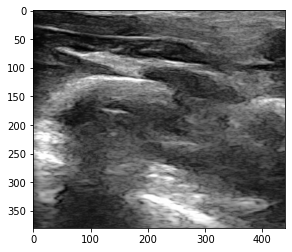

In [ ]:
testdir = root + 'test/'
savedir = root + 'results/'

imgname = testdir + 'img_' + str(49) + '.png'
noisy_img = np.float32(cv2.imread(imgname,0))
noisy_img = tor.from_numpy(noisy_img)
noisy_img_n = noisy_img.numpy()
noisy_img1 = ((noisy_img_n - noisy_img_n.min()) / (noisy_img_n.max() - noisy_img_n.min()))

h,w = noisy_img.size()
noisy_img = np.expand_dims(noisy_img, axis=2)
noisy_img = tor.from_numpy(noisy_img).permute(2,0,1).unsqueeze(0).to(device)

res = net(noisy_img)
clean_img=res.cpu().detach().clone().cpu().numpy()
clean_img = tor.from_numpy(clean_img).squeeze()
clean_img = clean_img.numpy()
print(clean_img.shape)
 
clean_img1 = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min())
filename = savedir + 'copy of dncnn_threshold_b_test49.png'
cv2.imwrite(filename, clean_img)
plt.imshow(noisy_img1,cmap="gray")


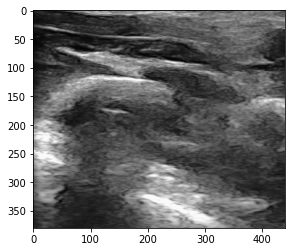

In [ ]:
plt.imshow(clean_img1,cmap="gray")